# Plots to analyze and understand our data

Start by importing necessary libraries:

In [1]:
import csv
from collections import defaultdict
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from DATASET import clean_df, numerical_df

                              Estudi Curs acadèmic  \
0  Graduat en Enginyeria Informàtica       2020/21   
1  Graduat en Enginyeria Informàtica       2020/21   
2  Graduat en Enginyeria Informàtica       2020/21   
3  Graduat en Enginyeria Informàtica       2020/21   
4  Graduat en Enginyeria Informàtica       2020/21   

                          Id Anonim  Sexe                 Assignatura  \
0  1DFB71F2B000D1421808D0B3F67B335E  Home                     Àlgebra   
1  1DFB71F2B000D1421808D0B3F67B335E  Home                      Càlcul   
2  1DFB71F2B000D1421808D0B3F67B335E  Home  Electricitat i Electrònica   
3  1DFB71F2B000D1421808D0B3F67B335E  Home      Fonaments d'Enginyeria   
4  1DFB71F2B000D1421808D0B3F67B335E  Home     Fonaments d'Informàtica   

   Codi assignatura  Nota_assignatura     Via Accés Estudi  Nota d'accés  \
0            103801               0.0  BATX. / COU AMB PAU        10.798   
1            103802               0.0  BATX. / COU AMB PAU        10.798   
2       

Import all relevant files, as well as our merged dataset: 

In [2]:
file1 = './Students/Estudiants_èxit_accés_anònim.csv'
file2 = './Students/Estudiants_notes_assignatures_anònim.csv'
file3 = './Students/Estudiants_abandonament_anònim.csv'

## 1. Histogram of final grades

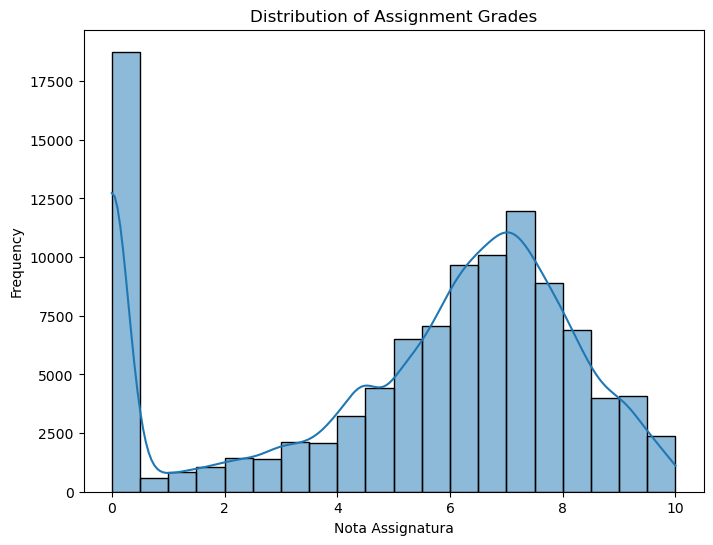

In [3]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_df['nota_assignatura'], kde=True, bins=20)
plt.title('Distribution of Assignment Grades')
plt.xlabel('Nota Assignatura')
plt.ylabel('Frequency')
plt.show()



 > From the plot, we can see that there are many cases where students received a grade of 0. While the most common grades lie in the range between 4 and 10. We should inspect where all these zeros come from, if they are really student's marks or if they are related to other factors such as drop out.



In [4]:
df_unique = clean_df.drop_duplicates(subset=['id_anonim'])
df_nota_cero = df_unique[df_unique['nota_assignatura'] == 0]
#print(df_nota_cero[['id_anonim', 'nota_d_acces', 'nota_assignatura']])

print("\nConteo de alumnos con nota 0 sin repetir id:")
print(df_nota_cero['nota_assignatura'].value_counts())

df_nota_cero_total = clean_df[clean_df['nota_assignatura'] == 0]
#print(df_nota_cero_total[['id_anonim', 'nota_d_acces', 'nota_assignatura']])
print("\nConteo de alumnos con nota 0 en total:")
print(df_nota_cero_total['nota_assignatura'].value_counts())

#Print els 5 primers alumnes amb nota 0
print("\nPrimeres 5 alumnes amb nota 0:")
resumen_suspensos = df_nota_cero_total.groupby('id_anonim').agg({
    'nota_assignatura': list,  # Notas con las que ha suspendido (deberían ser ceros)
    'assignatura': list,       # Asignaturas en las que ha suspendido
    'curs_academic': lambda x: sorted(set(x)),  # Años cursados
    'taxa_exit': list,        # Tasa de éxito
}).reset_index()

# Añadir número de años cursados
resumen_suspensos['num_anys_cursats'] = resumen_suspensos['curs_academic'].apply(len)

# Mostrar ejemplo de los primeros 5 alumnos
print(resumen_suspensos.head(5))


Conteo de alumnos con nota 0 sin repetir id:
0.0    248
Name: nota_assignatura, dtype: int64

Conteo de alumnos con nota 0 en total:
0.0    18304
Name: nota_assignatura, dtype: int64

Primeres 5 alumnes amb nota 0:
                          id_anonim  \
0  0066119860f58ba306ac800f52623ac0   
1  00665c4df2b06078706c9c96e9f6c117   
2  0082201cb9ab09cfd6556b10ee6844de   
3  00b029250c1614ff1cd14c5fb7bd70d3   
4  00db10edb3f63b6caafe420dc0b06811   

                                    nota_assignatura  \
0                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1                          [0.0, 0.0, 0.0, 0.0, 0.0]   
2                                              [0.0]   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         assignatura       curs_academic  \
0  [Àlgebra, Càlcul, Electricitat i electrònica, ...           [2023/24]   
1  [Càlcul, Fonaments dels computadors, Matemàtic...        

We filtered the students of drop_out based on mark of the subject.
Also we count the number of times that they had a 0.

In [5]:
# Filtramos los estudiantes con nota 0
students_with_zero_grades = clean_df[clean_df['nota_assignatura'] == 0]

# Agrupar por 'Id Anonim' y contar cuántos años diferentes han cursado cada estudiante
students_with_zero_grades['num_anys_cursats'] = students_with_zero_grades.groupby('id_anonim')['curs_academic'].transform('nunique')

# Contamos cuántos estudiantes con nota 0 han cursado más de un año académico
students_continued = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] > 1]
students_continued_count = students_continued['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que han continuado (más de un año académico): {students_continued_count}")

# Ahora, contamos cuántos estudiantes con nota 0 solo han cursado un año académico (posible abandono)
students_one_year = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] == 1]

students_one_year_count = students_one_year['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que solo cursaron un año académico: {students_one_year_count}")

students_finish = students_with_zero_grades[students_with_zero_grades['num_anys_cursats'] >= 4]
students_finish_count = students_finish['nota_assignatura'].count()
print(f"Total de estudiantes con nota 0 que han terminado (más de 4 años académicos): {students_finish_count}")
# Distribución de asignaturas con nota 0
assignment_zero_counts = students_with_zero_grades['assignatura'].value_counts()
print(f"Distribución de asignaturas con nota 0:\n{assignment_zero_counts}")



Total de estudiantes con nota 0 que han continuado (más de un año académico): 10330
Total de estudiantes con nota 0 que solo cursaron un año académico: 7974
Total de estudiantes con nota 0 que han terminado (más de 4 años académicos): 1384
Distribución de asignaturas con nota 0:
Crèdits reconeguts                      2690
Arquitectura de computadors              846
Metodologia de la programació            749
Organització i gestió d'empreses         721
Xarxes                                   692
                                        ... 
Fonaments de la visió per computador       2
Ment i cervell i                           2
Fonaments d'aprenentatge automàtic         2
Fonaments matemàtics i                     2
Visió i aprenentatge                       2
Name: assignatura, Length: 97, dtype: int64


/var/folders/fd/1yvz_sg52155gclh596h25180000gn/T/ipykernel_16196/1281568352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students_with_zero_grades['num_anys_cursats'] = students_with_zero_grades.groupby('id_anonim')['curs_academic'].transform('nunique')


/var/folders/fd/1yvz_sg52155gclh596h25180000gn/T/ipykernel_16196/1752894656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')


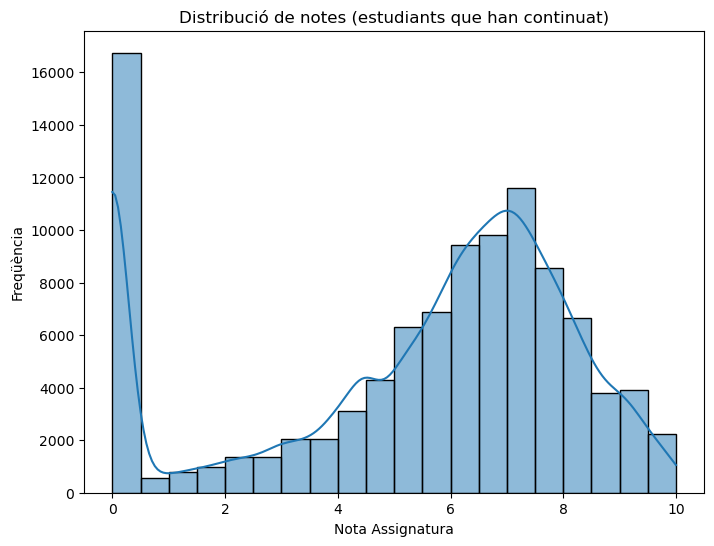

In [6]:
# Primero calculamos cuántos años ha cursado cada estudiante
clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')

# Filtramos solo los estudiantes que han cursado más de un año
students_multiyear = clean_df[clean_df['num_anys_cursats'] > 1]

# Hacemos el histograma de sus notas
plt.figure(figsize=(8, 6))
sns.histplot(students_multiyear['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants que han continuat)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()

/var/folders/fd/1yvz_sg52155gclh596h25180000gn/T/ipykernel_16196/3552346116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['taxa_exit'] = pd.to_numeric(clean_df['taxa_exit'], errors='coerce')


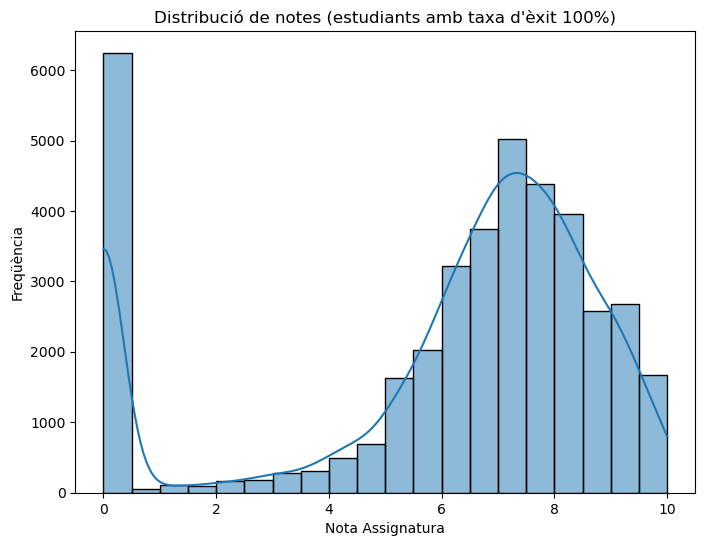

In [7]:
# Asegúrate de que 'taxa_exit' es numérico
clean_df['taxa_exit'] = pd.to_numeric(clean_df['taxa_exit'], errors='coerce')

# Filtra estudiantes con taxa d'èxit == 1.0
students_successful = clean_df[clean_df['taxa_exit'] == 1.0]

# Graficar las notas de asignatura para estos estudiantes
plt.figure(figsize=(8, 6))
sns.histplot(students_successful['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants amb taxa d\'èxit 100%)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()

In [8]:
# Asegurarse de tipos numéricos
students_multiyear = students_multiyear.drop_duplicates(subset=['id_anonim'])
students_multiyear['taxa_exit'] = pd.to_numeric(students_multiyear['taxa_exit'], errors='coerce')
students_multiyear['nota_assignatura'] = pd.to_numeric(students_multiyear['nota_assignatura'], errors='coerce')

# Filtrar incoherencias: taxa_exit = 1.0 pero nota = 0.0
incoherentes = students_multiyear[(students_multiyear['taxa_exit'] == 1.0) & (students_multiyear['nota_assignatura'] == 0.0)]

# Mostrar 5 ejemplos
print(incoherentes.head(5))


                                  estudi curs_academic  \
1045   Graduat en enginyeria informàtica       2020/21   
6740   Graduat en enginyeria informàtica       2020/21   
6919   Graduat en enginyeria informàtica       2020/21   
8020   Graduat en enginyeria informàtica       2020/21   
14164  Graduat en enginyeria informàtica       2020/21   

                              id_anonim  sexe                  assignatura  \
1045   B00d385b35cedafd7b69dd3c9a70734a  Dona                  Compiladors   
6740   510f91c0e300c04020d5ce078565b8f6  Home           Crèdits reconeguts   
6919   017301a753b1ef36dd045a4c2c6dc1df  Dona           Crèdits reconeguts   
8020   99de6321ce933121be75baee545b6041  Home  Arquitectura de computadors   
14164  1c67ef9064c3f30621d71d50c8e5d0bb  Home           Crèdits reconeguts   

       codi_assignatura  nota_assignatura     via_acces_estudi  nota_d_acces  \
1045             102782               0.0  Batx. / cou amb pau         6.376   
6740              7003

La majoria de gent que té un 0 a les assignatures només han cursat 2 anys.

Distribution of marks about the students that have finished the degree (4 or more years)

/var/folders/fd/1yvz_sg52155gclh596h25180000gn/T/ipykernel_16196/3907616362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')


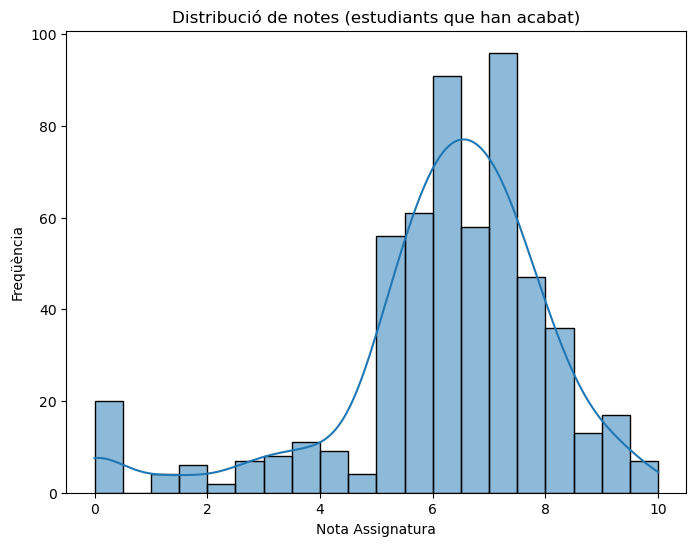

In [9]:
clean_df['num_anys_cursats'] = clean_df.groupby('id_anonim')['curs_academic'].transform('nunique')
students_finish = clean_df[clean_df['num_anys_cursats'] >= 4]
students_finish_unique = students_finish.drop_duplicates(subset='id_anonim', keep='first')
plt.figure(figsize=(8, 6))
sns.histplot(students_finish_unique['nota_assignatura'], kde=True, bins=20)
plt.title('Distribució de notes (estudiants que han acabat)')
plt.xlabel('Nota Assignatura')
plt.ylabel('Freqüència')
plt.show()


## 2. Identifying clusters in the data
This code will cluster students based on their background data and grades, and then compare the clusters. We will use KMeans clustering to group students based on their background and grades. We will also visualize the clusters using PCA for dimensionality reduction.

In [10]:
df_background = pd.read_csv(file1)

# Select and preprocess relevant features
df_background_filtered = df_background[[  
    'Id Anonim',
    'Sexe',
    'Via Accés Estudi',
    'Nota d\'accés (preinscripció)',
    'Dedicació de l\'estudiant',
    'Beca Concedida?',
]].dropna(subset=['Nota d\'accés (preinscripció)'])  # Ensure valid grades

# One-hot encode categorical variables
# Primero cargamos de nuevo el dataframe procesado
df = df_background_filtered.copy()

#### 1st Grouping: Id Anonim vs Nota d'accés

In [11]:
# we use DBSCAN to group closer grades
marks_scaler = StandardScaler()
scaled_marks = marks_scaler.fit_transform(df[['Nota d\'accés (preinscripció)']])

dbscan_marks = DBSCAN(eps=0.05, min_samples=1)  # small eps for similar marks
marks_clusters = dbscan_marks.fit_predict(scaled_marks)

# Save grades cluster
df['Cluster_same_grade'] = marks_clusters

#### 2nd Grouping: Id Anonim vs Características sociodemográficas

In [12]:
# Select characteristics to group
features = [
    'Beca Concedida?', 
    'Via Accés Estudi', 
    'Sexe',
    'Dedicació de l\'estudiant'
]

# encode categorical variables
df_features_encoded = pd.get_dummies(df[features], drop_first=True)

# Scale features
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(df_features_encoded)

# Clustering based on sociodemographic similarities
dbscan_features = DBSCAN(eps=0.5, min_samples=1)
clusters_features = dbscan_features.fit_predict(features_scaled)

# Save sociodemographical clustering
df['Cluster_profile'] = clusters_features

#### Result

In [13]:
# Show final dataframe
print(df[['Id Anonim', 'Nota d\'accés (preinscripció)', 'Cluster_same_grade', 'Cluster_profile']])

df_unique = df.drop_duplicates(subset=['Id Anonim'])

sns.set_theme(style="whitegrid")

                             Id Anonim  Nota d'accés (preinscripció)  \
0     1DFB71F2B000D1421808D0B3F67B335E                        10.798   
1     C26BD2D93ECB81CCB559D5B01B51475B                         6.512   
2     7526FB10E35C2E8808213E923F8F6125                        11.468   
3     FE20EBA7DC6B312D1F2FEA0A76D8E32D                        10.102   
4     22F995020F697929585BBADAC92CAB20                        10.870   
...                                ...                           ...   
5049  1DD45B64CD99F09F05CFD1494A2759D8                        10.306   
5050  B00599E75FAEA4201E19D6423F7A586F                        11.170   
5051  43E857A43F0C47B06C897EE1B5420859                        11.326   
5052  AB84122CC95E9606BF1105B1493AF177                        10.894   
5053  561BCC27E5BF6BF4318B71754314D3F2                         0.000   

      Cluster_same_grade  Cluster_profile  
0                      0                0  
1                      0                1  
2  

#### First Plot: Grouping by marks

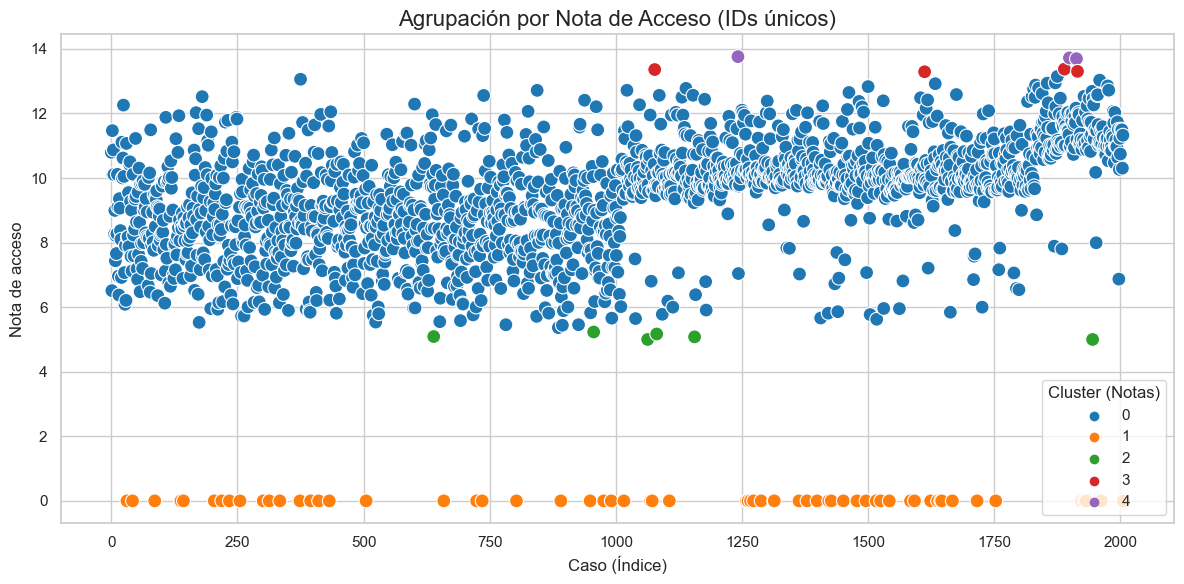

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=range(len(df_unique)),  # índice limpio
    y='Nota d\'accés (preinscripció)',
    hue='Cluster_same_grade',
    palette='tab10',
    data=df_unique,
    s=100
)
plt.title('Agrupación por Nota de Acceso (IDs únicos)', fontsize=16)
plt.xlabel('Caso (Índice)')
plt.ylabel('Nota de acceso')
plt.legend(title='Cluster (Notas)')
plt.tight_layout()
plt.show()

### Notas con 0

In [15]:
df_nota_cero = df_unique[df_unique['Nota d\'accés (preinscripció)'] == 0]

# Mostrar los resultados
print(df_nota_cero[['Id Anonim', 'Nota d\'accés (preinscripció)', 'Cluster_same_grade', 'Cluster_profile']])

# Además, podemos ver cuántos hay por cluster de nota
print("\nConteo de alumnos con nota 0 por cluster:")
print(df_nota_cero['Cluster_same_grade'].value_counts())

#Because is not assigned.
#Graduat en Enginyeria Informàtica,2020/21,831467D928E1E6F50F9FC15B8D8E2CB0,Home,2020/21,Sense assignar,0,Temps parcial,N,Sí,Sense assignar,Sense assignar,80%

                             Id Anonim  Nota d'accés (preinscripció)  \
31    543339F552E0B0E988D8BBBD6465185B                           0.0   
42    30278E0F8EC87AE905B2AB401F617D6F                           0.0   
86    831467D928E1E6F50F9FC15B8D8E2CB0                           0.0   
137   04A1AE722E3F56CC3436FA0B61780FEA                           0.0   
138   445BE2A471D3ED342F0A28E9001EB713                           0.0   
...                                ...                           ...   
4777  A0E10025CAC3F238A1AA7386278C6421                           0.0   
4787  24165D6D52FBA82831D8613682F9B864                           0.0   
4799  724BBB0359CC4FD95A904381D1ECCCFE                           0.0   
4886  927F18E8554CD4F63B5844CC1D2A1C84                           0.0   
5053  561BCC27E5BF6BF4318B71754314D3F2                           0.0   

      Cluster_same_grade  Cluster_profile  
31                     1               14  
42                     1               16  
86 

#### Second Plot: Sociodemographical Profile

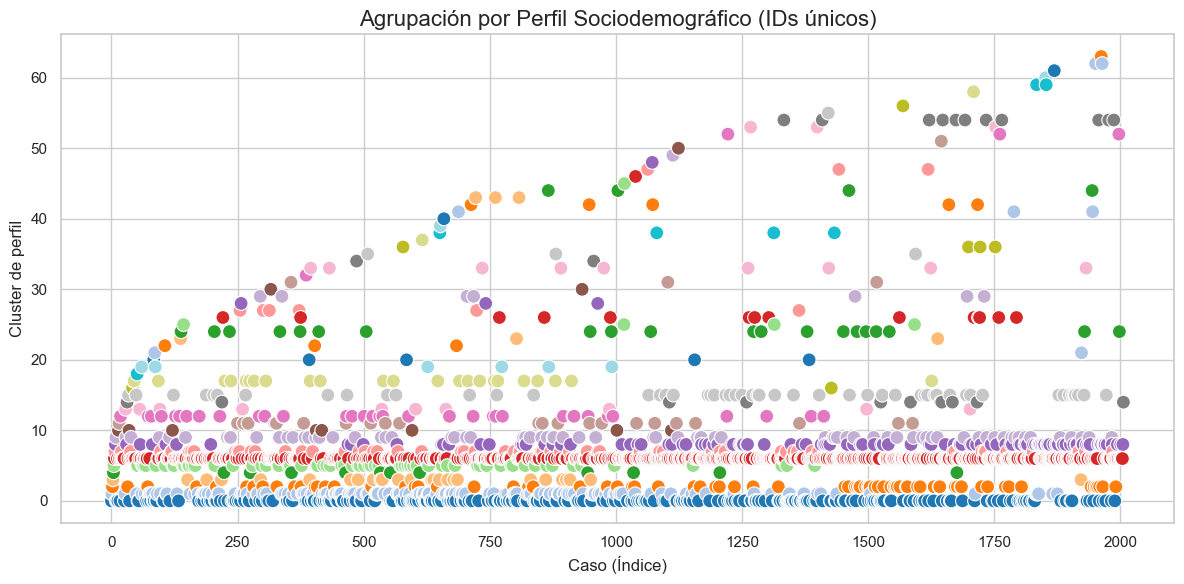

In [16]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    x=range(len(df_unique)),  
    y='Cluster_profile',
    hue='Cluster_profile',
    palette='tab20',
    data=df_unique,
    s=100
)
plt.title('Agrupación por Perfil Sociodemográfico (IDs únicos)', fontsize=16)
plt.xlabel('Caso (Índice)')
plt.ylabel('Cluster de perfil')
ax.legend_.remove()  # <-- REMOVED THE LEGEND SO THAT THE PLOT FITS!
plt.tight_layout()
plt.show()

## 3. Applying PCA in order to visualize our data

Here we will be working with our merged dataframe, our goal is to visualize its structure, in order to do so, we will reduce its dimensions to 3 principal components using PCA, and plot them in order to have some general idea about how our data looks like.

Since PCA can only be applied on numerical features, we will use the numerical version of our dataset, where we encoded the values into numbers.

In [17]:
# create a copy of our dataframe
df = numerical_df.copy()

# ensure that our dataframe only contains numerical values
df.dtypes

estudi                        int64
curs_academic                 int64
sexe                          int64
nota_assignatura            float64
via_acces_estudi              int64
nota_d_acces                float64
dedicacio_de_l_estudiant      int64
discapacitat                  int64
beca_concedida                int64
estudis_mare                  int64
estudis_pare                  int64
taxa_exit                   float64
abandonament                  int64
dificultat_assignatura      float64
dtype: object

We will now begin by scaling our data. Specifically, we will only scale the continuous features (such as the marks), as most of the other features are categorical.

In [18]:
# Select continuous features to scale
continuous_features = ['nota_assignatura', 'nota_d_acces', 'taxa_exit', 'dificultat_assignatura']

# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the continuous features
df[continuous_features] = scaler.fit_transform(df[continuous_features])

Next, we'll apply PCA to reduce the dataset's dimensionality to three principal components. 

In [19]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Apply PCA (exclude the target 'nota_assignatura')
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df.drop(columns=['nota_assignatura']))

# Create PCA result DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

Now we'll create a 3D plot where each point is colored based on the student's degree. This will allow us to see if there are any patterns or clusters in the data.

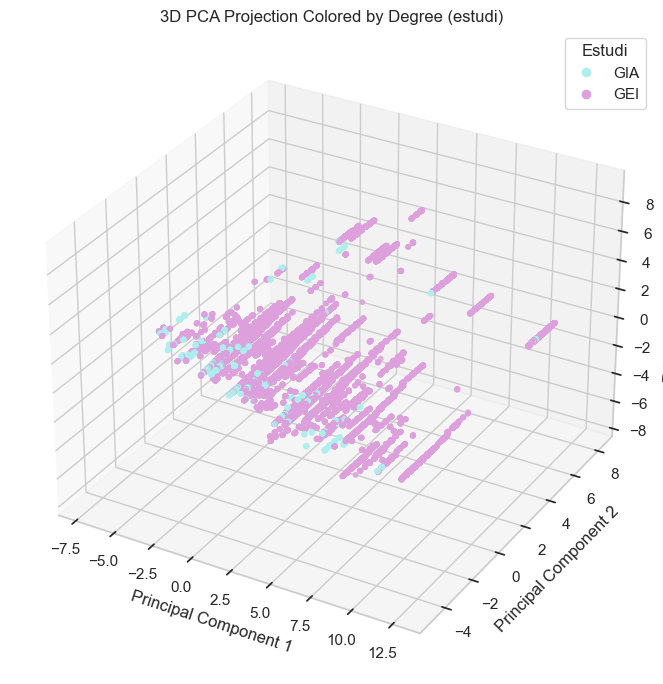

In [20]:
# Add the 'estudi' column back for coloring
pca_df['estudi'] = df['estudi'].values

# Set colors based on 'estudi' (0 or 1)
color_map = {0: 'paleturquoise', 1: 'plum'}
colors = pca_df['estudi'].map(color_map)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, alpha=0.8, s=10)

# Labels and title
ax.set_title('3D PCA Projection Colored by Degree (estudi)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='GIA', markerfacecolor='paleturquoise', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='GEI', markerfacecolor='plum', markersize=8)
]
ax.legend(handles=legend_elements, title="Estudi")

plt.tight_layout()
plt.show()


> The plot reveals that there are fewer AI students compared to Computer Science students. Most AI students appear to be concentrated in a specific region of the 3D space, whereas Computer Science students are more widely distributed throughout the entire space. This could signify that there are differences between the features of an AI degree student and the features of a computer science student (e.g. in the entrance grade required, final subject marks etc)

Now we will do the same but instead of coloring the points according to their degree, we will do so according to their gender:

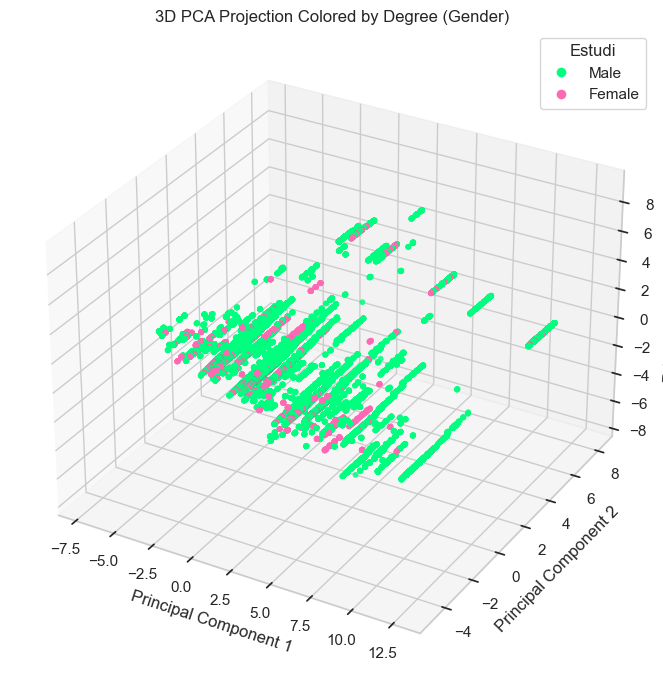

In [21]:
# Add the 'estudi' column back for coloring
pca_df['sexe'] = df['sexe'].values

# Set colors based on 'estudi' (0 or 1)
color_map = {0: 'springgreen', 1: 'hotpink'}
colors = pca_df['sexe'].map(color_map)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, alpha=0.8, s=10)

# Labels and title
ax.set_title('3D PCA Projection Colored by Degree (Gender)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='springgreen', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='hotpink', markersize=8)
]
ax.legend(handles=legend_elements, title="Estudi")

plt.tight_layout()
plt.show()

> The plot reveals that there are more male than female students across both degree programs. In terms of their distribution in the 3D space, the data points for both genders largely overlap, with no clear separation between the two groups. This suggests that gender does not significantly influence the features represented in the dataset.

## 4. Complementing PCA's results

All in all, even though we could extract some meaningful information from it, PCA was not as informative as we could have though. The reasons behind this could be that features are mainly shared across groups, or that PCA (being linear) might not be the best tool to separate our data. Therefore what we will do in this section is to focuse on those two features that we explored (degree and gender) as well as in other ones, in order to try to extract more information and complement our previous results.

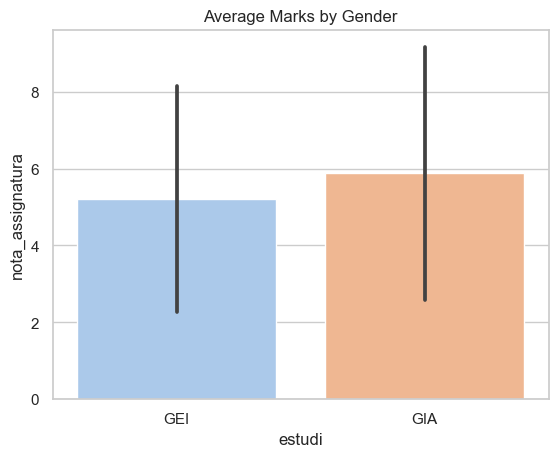

In [40]:
# Create a copy of the numerical DataFrame with names mapped
df = numerical_df.copy()
df['estudi'] = df['estudi'].map({0: 'GIA', 1: 'GEI'})

# Extract only the columns of interest
degree_df = df[['estudi', 'nota_assignatura']]

# Plot
sns.barplot(x='estudi', y='nota_assignatura', data=degree_df, errorbar='sd', palette='pastel')
plt.title('Average Marks by Gender')
plt.show()

> From the plot, we can conclude that students from the AI degree program have slightly higher performance than those from the Computer Science program. Therefore, the degree is an important feature that can help predict a student's mark. As we observe in the plot, the difference is not huge; however, it is still informative to know the degree to which a student belongs.

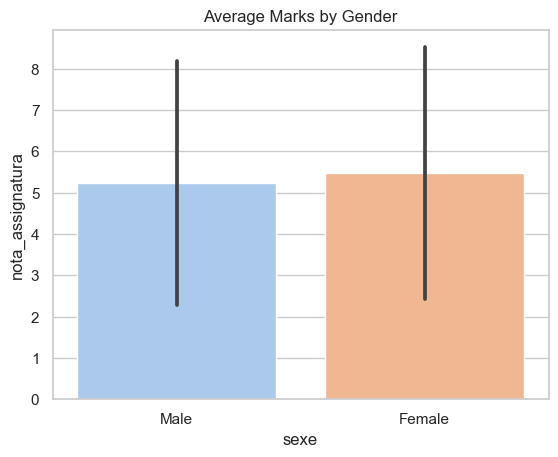

In [36]:
# Create a copy of the DataFrame with gender mapped
df = clean_df.copy()
df['sexe'] = df['sexe'].map({'Home': 'Male', 'Dona': 'Female'})

# Extract only the columns of interest
marks_df = df[['sexe', 'nota_assignatura']]

# Plot
sns.barplot(x='sexe', y='nota_assignatura', data=marks_df, errorbar='sd', palette='pastel')
plt.title('Average Marks by Gender')
plt.show()

> This plot confirms the pattern observed in the PCA analysis: the average marks of female and male students are very similar, with a slightly higher performance among female students. Nevertheless, this suggests that while gender may have a minor influence, it is not a key factor to consider when predicting student marks.

## 5. Exploring Feature Importance via Confusion Matrix Analysis

*add explanation*

In [ ]:
#CODE